In [3]:
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import numpy as np

In [4]:
def debug(text, debug_mode=True):
    """
    text: the text that preceed the debug message
    var: list of variables whose values are to be displayed
    """
    if debug_mode:
        print(text)

debug_flag=True

#### Parametri e condizioni iniziali

In [5]:
###########################################################################
# Dati sperimetali
molecules_per_uM = 500 # molecole/uM : circa 500 molecole per avere una concentrazione molare di 1 uM


###########################################################################
#  Parameters
n = 3 # hill parameter

alpha_1 = 0.2 # uM/ min
alpha_2 = alpha_1 

beta_1 = 4 # uM/ min
beta_2 = beta_1 

K1 = 1 # uM
K2 = K1

d1_base = 1 # 1/min. Si chiama base perchè è il valore per istanti iniziali (fra 0 e 60 min). Dopodichè aumenta (vedi dopo)
d2 = d1_base

gamma = 1 # 1/min

epsilon = 1

s = 1.7  # adimensional



###########################################################################
# Initial conditions
u_0_nmolecules = 2125 # numero di molecole!
v_0_nmolecules = 125 # numero di molecole!

def from_molecules_to_uM(molecules, molecules_per_uM):
    return molecules / molecules_per_uM

def from_uM_to_molecules(uM, molecules_per_uM):
    return uM * molecules_per_uM

# intial conditions in uM
u_0 = from_molecules_to_uM(u_0_nmolecules, molecules_per_uM)
v_0 = from_molecules_to_uM(v_0_nmolecules, molecules_per_uM)
print(f"Initial conditions: u_0 = {u_0:.2f} uM, v_0 = {v_0:.2f} uM")


###########################################################################
# MMC induction window
t_start = 60 # min
t_end = 960 # min


Initial conditions: u_0 = 4.25 uM, v_0 = 0.25 uM


**Riguardo al parametro d1:**

- d₁ è il tasso di degradazione della proteina λCI.

- Normalmente vale d₁ = 1 min⁻¹, ma quando la cellula subisce danno al DNA (indotto dalla mitomicina C, MMC) la proteina RecA si lega a λCI e ne aumenta la degradazione.

    - Prima e dopo l’induzione (t < 60 min o t > 960 min): d1 = d1_base = 1; 
    - Durante l’induzione (60 ≤ t ≤ 960 min): d1= d1_base + gamma*s / (1+s)
- Nel modello del paper la prima ora (t < 60 min) serve per far stabilizzare il sistema nello stato iniziale ad alto λCI. Invece il trattamento con MMC dura 15h, per questo dopo 960 min d1 torna al livello base

#### Modello deterministico


In [16]:
def make_toggle_switch_ode(alpha_1, beta_1, alpha_2, beta_2,
                           K1, K2, d1_base, n, d2, gamma, epsilon, t_start=60, t_end=960):
    """
    Factory for build genetic switch deterministic  model
    """

    def d1(t, s):
        if t < t_start or t > t_end:
            return d1_base
        else:
            return d1_base + gamma * s / (1 + s)
    
    def hill_function(x, K):
        """
        Function to be used in the ODEs to model the Hill function.
        Args:
            x : number of molecules of one of the two species (u or v)
            K : ? a parameter that sets the threshold for the Hill function
        """
        return K**n / (K**n + x**n)

    def genetic_switch_ode(t, y, s):
        u, v = y # current values. u= λCI, v = LacR
        du = ( epsilon * (alpha_1 + beta_1 * hill_function(v, K1)) ) - d1(t, s) * u
        dv = ( epsilon * (alpha_2 + beta_2 * hill_function(u, K2)) ) - d2 * v
        return [du, dv]

    return genetic_switch_ode



In [17]:
ode_system = make_toggle_switch_ode(alpha_1, beta_1, alpha_2, beta_2, K1, K2, d1_base, n, d2, gamma, epsilon)

t_sim = [0, 1400] # simulation time (min)
y0 = [u_0, v_0]
delta_t = 0.5

def run_sim(s, t_end=1200):
    sol = solve_ivp(lambda t, y: ode_system(t, y, s),
                    t_sim, y0, max_step=delta_t)
    return sol

# Try a few s values around the reported threshold range
s_values = [1.3, 1.7, 2.0, 10]
sims = [run_sim(s) for s in s_values]


In [29]:
from scipy.integrate._ivp.ivp import OdeResult

def plot_trajectories(s_values, sims):
    num_curves = len(s_values) 
    if num_curves>5: raise Exception("Too many curves. Max number with current setting is 6. If you need more, change the color list")
    # safety check: number of trajectories coincciide with number of s values

    # Plot curves
    plt.figure(figsize=(7,6))

    color_idx, color_list = 0, list(plt.colormaps['Paired'].colors)
    for s, sol in zip(s_values, sims):
        
        #load the solutitions
        if isinstance(sol, OdeResult):  #deterministic results
            t, u, v = sol.t, sol.y[0], sol.y[1]
            ylabel = "concentrations (μM)"
        else: #stochastic results
            t, u, v = sol
            ylabel = "number of molecules"


        #plot the curves
        plt.plot(t, u, color=color_list[color_idx],  label=f"s={s}, LacR ", linewidth=2)
        plt.plot(t, v, color=color_list[color_idx+1], label=f"s={s}, λCI ", linewidth=2)
        # plt.plot(t, u, color="red",  label=f"s={s}, LacR ", linewidth=1)
        # plt.plot(t, v, color="blue", label=f"s={s}, λCI ", linewidth=1)

        color_idx+=2

    plt.ylabel(ylabel)
    plt.xlabel("time (min)")
    plt.legend()
    plt.axvspan(t_start, t_end, alpha=0.05)
    plt.tight_layout()
    plt.show()
    


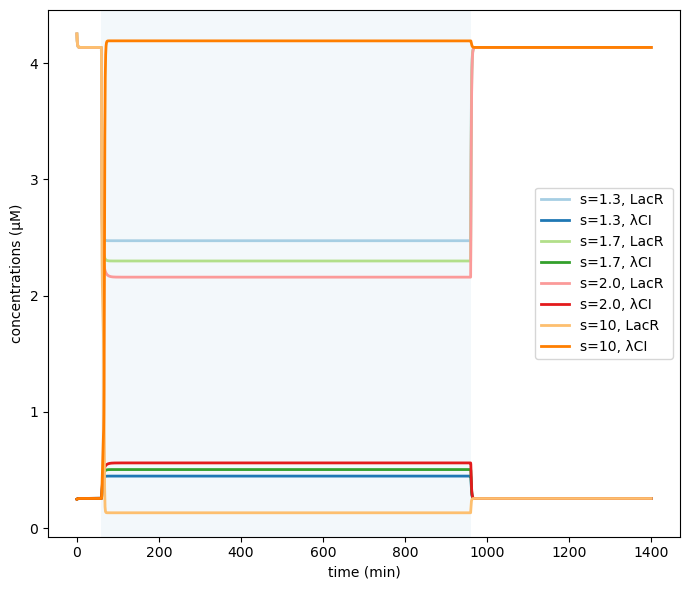

In [24]:
plot_trajectories(s_values, sims)

The deterministic model switches only for very big value of $s$!

#### Modello stocastico

NON FUNZIONA COSì, DA CAPIRE

In [31]:
def make_toggle_switch_stochastic(alpha_1, beta_1, alpha_2, beta_2,
                           K1, K2, d1_base, n, d2, gamma, epsilon, u_0_nmolecules, v_0_nmolecules, t_start=60, t_end=1200):
    """
    Factory for build genetic switch stochastic (tau-leap) model
    """

    def d1(t, s):
        if t < t_start or t > t_end:
            return d1_base
        else:
            return d1_base + gamma * s / (1 + s)
    
    def hill_function(x, K):
        """
        Function to be used in the ODEs to model the Hill function.
        Args:
            x : number of molecules of one of the two species (u or v)
            K : ? a parameter that sets the threshold for the Hill function
        """
        return K**n / (K**n + x**n) 

    def genetic_switch_stochastic(tau, s, enable_bimodal_sampling=False):
        """
        One stochastic trajectory via Poisson tau-leap for the SOS-interfaced toggle.
        Returns times, u, v arrays.
        """
        ### convert the parameters from concentrations to molecular numbers
        alpha_1_nmol = 500 * alpha_1
        beta_1_nmol =  500 * beta_1
        alpha_2_nmol =  500 * alpha_2
        beta_2_nmol =  500 * beta_2
        K1_nmol  =  500 * K1
        K2_nmol =  500 * K2
        debug(f"Parameters converted:\n\talpha_1_nmol:{alpha_1_nmol}, beta_1_nmol: {beta_1_nmol},\n\talpha_2_nmol: {alpha_2_nmol}, beta_2_nmol: {beta_2_nmol},\n\tK1_nmol: {K1_nmol}, K2_nmol: {K2_nmol}\n")
        

        ### initializiation and initial conditions
        steps = int(np.ceil(t_end/tau))

        t = [0.0] ## maybe update because of slowleness of lists
        u = [u_0_nmolecules]
        v = [v_0_nmolecules]

        debug(f"Step 0:\n sim time 0.0 min:\nInitial nr of molecules:\n\tu: {u[0]}, v: {v[0]} \n-----------------------\n", debug_flag)
        if u[0]<0 or v[0] < 0: raise Exception("Got negative value for inital molecular number: non valid")
 
        rng = np.random.default_rng() #generatore di numeri casuali


        ### tau-leap algorithm with post-leap check
        k=0
        current_tau = tau
        tk = t[0]
        while tk < t_end and current_tau > 0.01 and k < 10000: # if t reaches the t_end or tau reaches the inferior threshold, exit the loop

            uk, vk = u[-1], v[-1] #previous values (needed to compute updates)

            ### propensity rates (molecules/min)
            prop_u = epsilon * (alpha_1_nmol + beta_1_nmol * hill_function(vk, K1_nmol))
            prop_v = epsilon * (alpha_2_nmol + beta_2_nmol * hill_function(uk, K2_nmol))
            #debug(f"prop_u: {prop_u}, prop_v: {prop_v}",  debug_flag)
            if prop_u<0 or prop_v < 0: raise Exception("Got negative value for propensity functions: non valid as the Poisson mean must be positive")#ensure that the mean is not negative: poisson property

            ### degradation rates (molecules/min)
            deg_u = d1(tk, s) * uk #ensure number of molecules is not negative, otherwise subtracting deg_ in the updates will lead to an increase 
            deg_v = d2 * vk 
            #debug(f"deg_u: {deg_u}, deg_v: {deg_v}",  debug_flag)
            if deg_u<0 or deg_v < 0: raise Exception("Got negative value for propensity functions: non valid as the Poisson mean must be positive")#ensure that the mean is not negative: poisson property


            ### Poisson jumps with mean = rate*tau for the increase
            #sampling number of molecules produced
            dU_increase = rng.poisson(prop_u * current_tau) 
            dV_increase = rng.poisson(prop_v * current_tau)
            #debug(f"dU_increase: {dU_increase}, dV_increase: {dV_increase}",  debug_flag)

            # sampling number of molecules degradated 
            if enable_bimodal_sampling:
                print("TODO")
            #     # Binomial jumps (degradation) starting from total propensities deg_u = d1*uk, deg_v = d2*vk
            #     if uk > 0:
            #         p_u = 1.0 - np.exp(-(deg_u / uk) * tau)   # per-molecule probability (GPT)
            #         dU_decrease = rng.binomial(int(uk), p_u)
            #     else:
            #         dU_decrease = 0

            #     if vk > 0:
            #         p_v = 1.0 - np.exp(-(deg_v / vk) * tau) # per-molecule probability (GPT)
            #         dV_decrease = rng.binomial(int(vk), p_v)
            #     else:
            #         dV_decrease = 0
            
            else: #leap check strategy
                dU_decrease = rng.poisson(deg_u * current_tau)
                dV_decrease = rng.poisson(deg_v * current_tau)
            #debug(f"dU_decrease: {dU_decrease}, dV_decrease: {dV_decrease}",  debug_flag)


            ### updates
            uk = uk + dU_increase - dU_decrease
            vk = vk + dV_increase - dV_decrease

            #Post leap check:
            if uk < 0 or vk < 0:
                debug("**************************************\nGot negative values for the updates, discarding the updates and repeating the step after dividing tau by half")
                
                current_tau /= 2
                debug(f"Updated tau: {current_tau} min\n**************************************")        
        
            else: 
                tk += current_tau #update time: this is the current time of simulation

                k += 1 #update step

                #storing values
                t.append(tk) # current time of sim
                u.append(uk)
                v.append(vk)
                

                debug(f"Step {k+1}:\t\t sim time: {tk+tau} min \t\tu: {uk}, v: {vk}", debug_flag)

        if t[-1] < t_end: debug(f"Simulation failed because of threshold for tau reached.\n Time achieved: {t[-1]}")
        else: debug("GRANDIOSO SUCESSO")

        t = np.array(t)
        u = np.array(u)
        v = np.array(v)

        return t, u, v
    
    return genetic_switch_stochastic



In [38]:
stochastic_model = make_toggle_switch_stochastic(alpha_1, beta_1, alpha_2, beta_2, K1, K2, d1_base, n, d2, gamma, epsilon, u_0_nmolecules, v_0_nmolecules)

# Try a few s values around the reported threshold range
s_values = [1.7]
tau = 1
sims = [stochastic_model(tau, s) for s in s_values]


Parameters converted:
	alpha_1_nmol:100.0, beta_1_nmol: 2000,
	alpha_2_nmol: 100.0, beta_2_nmol: 2000,
	K1_nmol: 500, K2_nmol: 500

Step 0:
 sim time 0.0 min:
Initial nr of molecules:
	u: 2125, v: 125 
-----------------------

Step 2:		 sim time: 2.0 min 		u: 2176, v: 164
Step 3:		 sim time: 3.0 min 		u: 1986, v: 127
Step 4:		 sim time: 4.0 min 		u: 1956, v: 125
Step 5:		 sim time: 5.0 min 		u: 2087, v: 147
Step 6:		 sim time: 6.0 min 		u: 2058, v: 138
Step 7:		 sim time: 7.0 min 		u: 2103, v: 131
Step 8:		 sim time: 8.0 min 		u: 2056, v: 129
Step 9:		 sim time: 9.0 min 		u: 2044, v: 127
Step 10:		 sim time: 10.0 min 		u: 2125, v: 105
Step 11:		 sim time: 11.0 min 		u: 2204, v: 111
Step 12:		 sim time: 12.0 min 		u: 2112, v: 138
Step 13:		 sim time: 13.0 min 		u: 2101, v: 123
Step 14:		 sim time: 14.0 min 		u: 2128, v: 152
Step 15:		 sim time: 15.0 min 		u: 2063, v: 123
Step 16:		 sim time: 16.0 min 		u: 2075, v: 136
Step 17:		 sim time: 17.0 min 		u: 2068, v: 136
Step 18:		 sim time: 

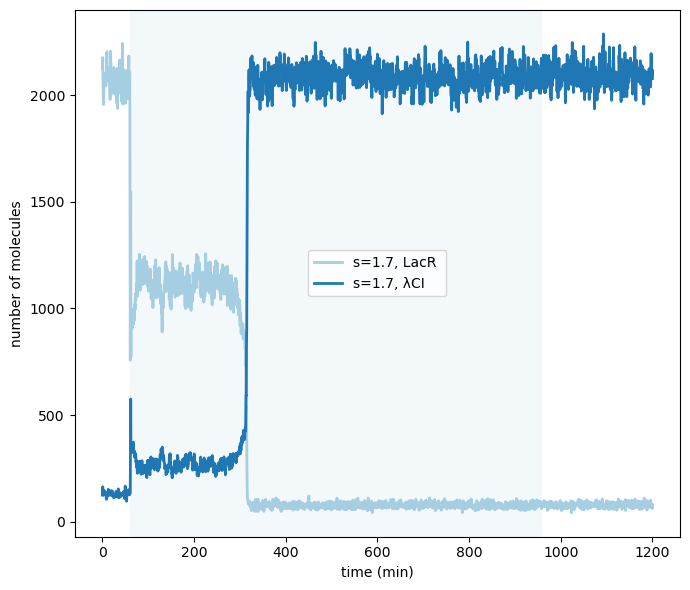

In [39]:
plot_trajectories(s_values, sims)


il tau-leap “puro” a salti Poisson può capitare che le reazioni di degradazione sottraggano più molecole di quante ne hai, portando a valori negativi. Nella pratica si usano alcune strategie standard per evitarlo, fra cui *Post-leap check + riduzione adattiva di τ*:

- Fai il leap;
- Se $u_{k+1}<0$ o $v_{k+1}<0$ annulla quello step, dimezza τ e riesegui il campionamento. Ripeti finché non hai aggiornamenti validi (o fino a un minimo τ).